In [1]:
%pylab inline

import numpy as np
import pandas as pd

from sklearn.linear_model import Lasso

from tools import load_household_power_consumption
from tools import to_timeseries
from tools import split_train_test
from tools import vis_evaluate

from pprint import pprint as pp
from IPython.display import display

np.random.seed(0)

Populating the interactive namespace from numpy and matplotlib


# Dataset

[UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Individual+household+electric+power+consumption) 에서 다운받을 수 있습니다.


1. **date**: Date in format dd/mm/yyyy
2. **time**: time in format hh:mm:ss
3. **global_active_power**: household global minute-averaged active power (in kilowatt). Global active power is the power consumed by appliances other than the appliances mapped to Sub Meters. Global active power is the real power consumption i.e. the power consumed by electrical appliances other than the sub metered appliances.It is basically called wattfull power.
4. **global_reactive_power**: household global minute-averaged reactive power (in kilowatt). Global reactive power is the power which bounces back and froth without any usage or leakage. It is the imaginary power consumption. It is basically called wattless power.
5. **voltage**: minute-averaged voltage (in volt)

6. **global_intensity**: household global minute-averaged current intensity (in ampere). Intensity is magnitude of the power consumed. Also called as strength of current.

7. **sub_metering_1**: energy sub-metering No. 1 (in watt-hour of active energy). It corresponds to the kitchen, containing mainly a dishwasher, an oven and a microwave (hot plates are not electric but gas powered).

8. **sub_metering_2**: energy sub-metering No. 2 (in watt-hour of active energy). It corresponds to the laundry room, containing a washing-machine, a tumble-drier, a refrigerator and a light.

9. **sub_metering_3**: energy sub-metering No. 3 (in watt-hour of active energy). It corresponds to an electric water-heater and an air-conditioner.

10. **diff_next**: 다음시간대와 비교하여 difference


하려고 하는 것은 [유효전력(global active power)](http://www.ktword.co.kr/abbr_view.php?m_temp1=4091)를 예측하는 것입니다.


# Configuration

In [2]:
PREDICT_SIZE = 64
BATCH_SIZE = 2048

# Load Dataset

In [31]:
dataset, data_x, data_y = load_household_power_consumption()

# Add Y
dataset['active_power_p'] = dataset['active_power'].shift(PREDICT_SIZE)
dataset.dropna(inplace=True)
display(dataset.head())


2017-08-22 17:28:29,900 [hybrid-lstm.tool | INFO] Load existing dataset


,active_power,reactive_power,voltage,intensity,sub1,sub2,sub3,diff_next,active_power_p
datetime,,,,,,,,,
2010-10-27 14:44:00,0.374,0.064,250.78,1.6,0.0,0.0,1.0,60.0,0.596
2010-10-27 14:45:00,0.344,0.064,250.47,1.4,0.0,0.0,1.0,60.0,0.576
2010-10-27 14:46:00,0.336,0.062,249.66,1.4,0.0,0.0,0.0,60.0,0.524
2010-10-27 14:47:00,0.374,0.000,249.97,1.6,0.0,0.0,1.0,60.0,0.524
2010-10-27 14:48:00,0.420,0.046,250.26,1.6,0.0,0.0,1.0,60.0,0.520


## Active Power

In [57]:
def foo(x):
    h = x.hour
    if x.minute >= 30:
        h += 0.5
    return h

dataset['hour'] = dataset.index.map(foo)
pd.get_dummies(dataset, prefix='h', columns=['hour'])

,active_power,reactive_power,voltage,intensity,sub1,sub2,sub3,diff_next,active_power_p,h_0.0,...,h_19.0,h_19.5,h_20.0,h_20.5,h_21.0,h_21.5,h_22.0,h_22.5,h_23.0,h_23.5
datetime,,,,,,,,,,,,,,,,,,,,,
2010-10-27 14:44:00,0.374,0.064,250.78,1.6,0.0,0.0,1.0,60.0,0.596,0,...,0,0,0,0,0,0,0,0,0,0
2010-10-27 14:45:00,0.344,0.064,250.47,1.4,0.0,0.0,1.0,60.0,0.576,0,...,0,0,0,0,0,0,0,0,0,0
2010-10-27 14:46:00,0.336,0.062,249.66,1.4,0.0,0.0,0.0,60.0,0.524,0,...,0,0,0,0,0,0,0,0,0,0
2010-10-27 14:47:00,0.374,0.000,249.97,1.6,0.0,0.0,1.0,60.0,0.524,0,...,0,0,0,0,0,0,0,0,0,0
2010-10-27 14:48:00,0.420,0.046,250.26,1.6,0.0,0.0,1.0,60.0,0.520,0,...,0,0,0,0,0,0,0,0,0,0
2010-10-27 14:49:00,0.424,0.046,250.36,1.8,0.0,0.0,0.0,60.0,0.522,0,...,0,0,0,0,0,0,0,0,0,0
2010-10-27 14:50:00,0.424,0.048,250.84,1.8,0.0,0.0,1.0,60.0,0.520,0,...,0,0,0,0,0,0,0,0,0,0
2010-10-27 14:51:00,0.422,0.046,250.47,1.8,0.0,0.0,1.0,60.0,0.518,0,...,0,0,0,0,0,0,0,0,0,0
2010-10-27 14:52:00,0.422,0.046,250.56,1.8,0.0,0.0,0.0,60.0,0.520,0,...,0,0,0,0,0,0,0,0,0,0


## Pearson Correlation

active_power_p    1.000000
active_power      0.441844
intensity         0.438859
voltage           0.361758
sub3              0.319099
sub1              0.147609
sub2              0.143457
reactive_power    0.071277
diff_next         0.000454
Name: active_power_p, dtype: float64

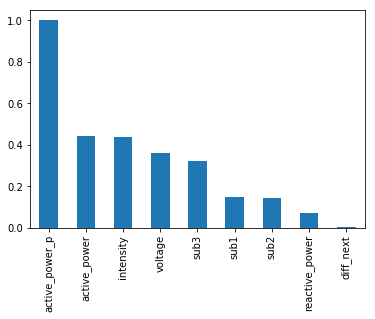

In [35]:
def show_correlation(data):
    d = np.sqrt((data.corr()['active_power_p']**2)).sort_values(ascending=False)
    display(d)
    d.plot(kind='bar')
    
show_correlation(dataset)

## Scatter Plots

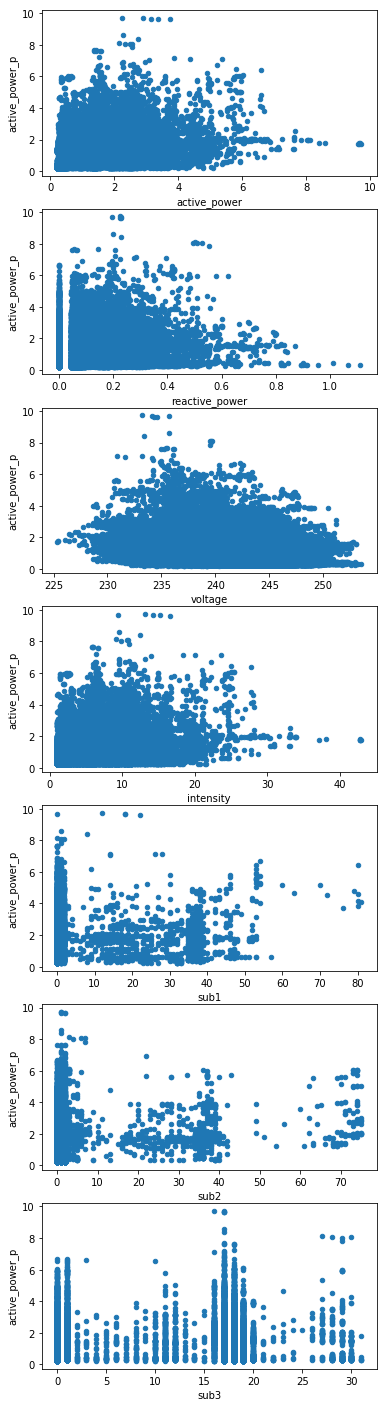

In [33]:
fig, plots = subplots(7, 1)
fig.set_figheight(25)

dataset.plot('active_power', 'active_power_p', kind='scatter', ax=plots[0])
dataset.plot('reactive_power', 'active_power_p', kind='scatter', ax=plots[1])
dataset.plot('voltage', 'active_power_p', kind='scatter', ax=plots[2])
dataset.plot('intensity', 'active_power_p', kind='scatter', ax=plots[3])
dataset.plot('sub1', 'active_power_p', kind='scatter', ax=plots[4])
dataset.plot('sub2', 'active_power_p', kind='scatter', ax=plots[5])
dataset.plot('sub3', 'active_power_p', kind='scatter', ax=plots[6])